In [1]:
#pip installs for google colab
"""!pip install yfinance
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install bs4
!pip install requests"""

'!pip install yfinance\n!pip install pandas\n!pip install numpy\n!pip install matplotlib\n!pip install scikit-learn\n!pip install torch\n!pip install bs4\n!pip install requests'

In [2]:
#imports
import requests
import yfinance as yf
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable
import dateutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Pytorch configuration

In [3]:
#enable or diable GPU compute
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(device))
else:
    device = torch.device('cpu')

GeForce GTX 980


Network definition

In [4]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, tickerName):
        super(RNN, self).__init__()
        self.tickerName=tickerName

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

Get the tickers of the companies in the Stock and Poor's Top 500

In [5]:
def getTickersSP500():
  LIST_OF_COMPANIES_WIKI = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
  website_url = requests.get(LIST_OF_COMPANIES_WIKI).text
  soup = BeautifulSoup(website_url, "html.parser")
  my_table = soup.find('table',{'class':'wikitable sortable', 'id': "constituents"})
  label_items = my_table.findAll('a', {'class': 'external text', 'rel': 'nofollow'})
  labels = []
  for label_item in label_items:
    label = label_item.get_text()
    if label == 'reports' or label == 'Aptiv Plc':
        continue
    labels.append(label)
  return labels

Create training and test dataset out of the the stock history

In [6]:
def createTrainTestDataset(tickerName):
  #error checking for old/invalid tickers
  #return 1 for invalid dimensions
  #since yfinance returns an empty df on error
  ticker = yf.Ticker(tickerName)
  data_set = ticker.history(period="max")
  data_set = data_set[data_set.index>dateutil.parser.parse("2009-06-01")]
  data_set = data_set.drop(['Dividends', 'Stock Splits', 'High', 'Low', 'Close','Volume'], axis = 1)
  train_set, test_set = train_test_split(data_set, test_size=0.2, train_size=0.8, shuffle=False)
  sc = MinMaxScaler(feature_range = (0, 1))
  train_fit = sc.fit(train_set)
  train_scaled = sc.transform(train_set)
  # Creating a data structure with 60 timesteps and 1 output
  x_train = []
  y_train = []
  for i in range(INPUT_SIZE, train_scaled.shape[0]):
    x_train.append(train_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(train_scaled[i, 0])
  x_train, y_train = np.array(x_train), np.array(y_train)

  # Reshaping
  x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
  return x_train, y_train, train_set, test_set, sc

Function definition to establish hyper-parameters and return network

In [7]:
# network hyper parameters
INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 1
OUTPUT_SIZE = 1
learning_rate = 0.001
num_epochs = 100

def createNetwork(tickerName):
  rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, tickerName).to(device)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
  hidden_state = None
  return rnn, optimizer, criterion, hidden_state

Train the neural network using the training data

In [8]:
def trainNetwork(network, optimizer, criterion, hidden_state):
  for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(x_train).float()).to(device)
    labels = Variable(torch.from_numpy(y_train).float()).to(device)
    output, hidden_state = network(inputs, hidden_state)
    loss = criterion(output.view(-1), labels)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimizer.step()                                     # update the parameters
    torch.cuda.empty_cache()
    print('epoch {}, loss {}'.format(epoch,loss.item()))

In [9]:
def testNetwork(network, x_train, y_train, train_set, test_set, sc):
  real_stock_price = test_set.values
  total_set = pd.concat((train_set['Open'], test_set['Open']), axis = 0)
  inputs = total_set[len(total_set) - len(test_set) - INPUT_SIZE:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)

  x_test = []
  for i in range(INPUT_SIZE, inputs.shape[0]):
      x_test.append(inputs[i-INPUT_SIZE:i, 0])
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

  x_train_x_test = np.concatenate((x_train, x_test),axis=0)
  hidden_state = None
  test_inputs = Variable(torch.from_numpy(x_train_x_test).float()).cuda()
  predicted_stock_price, b = network(test_inputs, hidden_state)
  predicted_stock_price = np.reshape(predicted_stock_price.detach().cpu().numpy(), (test_inputs.shape[0], 1))
  predicted_stock_price = sc.inverse_transform(predicted_stock_price)

  real_stock_price_all = np.concatenate((train_set[INPUT_SIZE:], real_stock_price))
  print(real_stock_price_all.shape)
  print(predicted_stock_price.shape)
  # Visualising the results
  plt.figure(1, figsize=(12, 5))
  plt.plot(real_stock_price_all, color = 'red', label = 'Real')
  plt.plot(predicted_stock_price, color = 'blue', label = 'Pred')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

epoch 0, loss 0.311527281999588
epoch 1, loss 0.21535910665988922
epoch 2, loss 0.1394014209508896
epoch 3, loss 0.08157200366258621
epoch 4, loss 0.04035978391766548
epoch 5, loss 0.014616858214139938
epoch 6, loss 0.003174669574946165
epoch 7, loss 0.004004072397947311
epoch 8, loss 0.012721581384539604
epoch 9, loss 0.022521160542964935
epoch 10, loss 0.02843690663576126
epoch 11, loss 0.029339611530303955
epoch 12, loss 0.02634151093661785
epoch 13, loss 0.021199090406298637
epoch 14, loss 0.015504628419876099
epoch 15, loss 0.010388091206550598
epoch 16, loss 0.006478505674749613
epoch 17, loss 0.003985147923231125
epoch 18, loss 0.0028204366099089384
epoch 19, loss 0.002720970893278718
epoch 20, loss 0.0033460697159171104
epoch 21, loss 0.004349699709564447
epoch 22, loss 0.005430231802165508
epoch 23, loss 0.006360882893204689
epoch 24, loss 0.007000215817242861
epoch 25, loss 0.007286240346729755
epoch 26, loss 0.007221382111310959
epoch 27, loss 0.006854499224573374
epoch 28, 

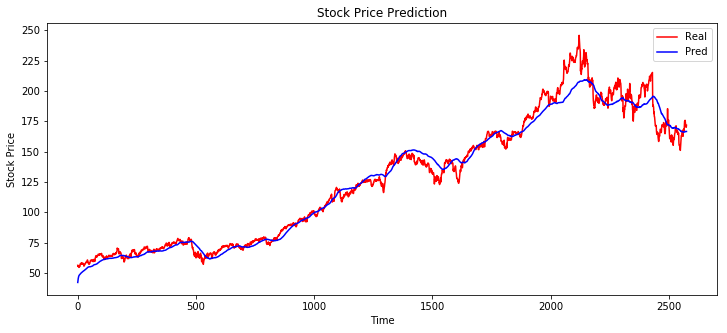

epoch 0, loss 0.2192484438419342
epoch 1, loss 0.15002989768981934
epoch 2, loss 0.09412193298339844
epoch 3, loss 0.05109899863600731
epoch 4, loss 0.021444011479616165
epoch 5, loss 0.005948198493570089
epoch 6, loss 0.004588954616338015
epoch 7, loss 0.013798256404697895
epoch 8, loss 0.024275977164506912
epoch 9, loss 0.029163435101509094
epoch 10, loss 0.027948297560214996
epoch 11, loss 0.022931210696697235
epoch 12, loss 0.016651473939418793
epoch 13, loss 0.01094493642449379
epoch 14, loss 0.006786251440644264
epoch 15, loss 0.004442471079528332
epoch 16, loss 0.0037153800949454308
epoch 17, loss 0.004166073631495237
epoch 18, loss 0.005281213670969009
epoch 19, loss 0.006582929752767086
epoch 20, loss 0.007700471673160791
epoch 21, loss 0.008406258188188076
epoch 22, loss 0.008612435311079025
epoch 23, loss 0.00834200344979763
epoch 24, loss 0.007692576851695776
epoch 25, loss 0.00680234469473362
epoch 26, loss 0.0058214180171489716
epoch 27, loss 0.004889035597443581
epoch 28

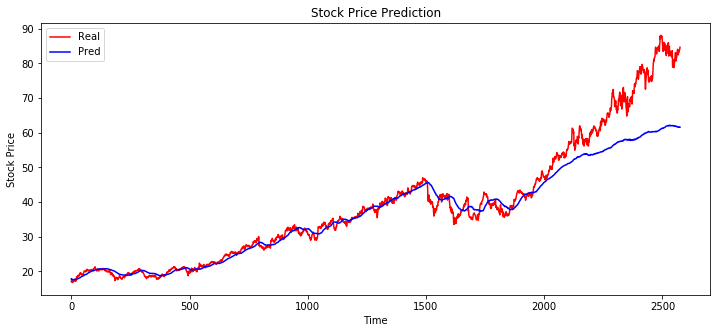

epoch 0, loss 0.20417018234729767
epoch 1, loss 0.1405337005853653
epoch 2, loss 0.09053504467010498
epoch 3, loss 0.052872419357299805
epoch 4, loss 0.02632918767631054
epoch 5, loss 0.010052992030978203
epoch 6, loss 0.0033121234737336636
epoch 7, loss 0.0047766780480742455
epoch 8, loss 0.01140530128031969
epoch 9, loss 0.018437739461660385
epoch 10, loss 0.02237345650792122
epoch 11, loss 0.02251863107085228
epoch 12, loss 0.019860954955220222
epoch 13, loss 0.015821941196918488
epoch 14, loss 0.011619559489190578
epoch 15, loss 0.008057152852416039
epoch 16, loss 0.005526842549443245
epoch 17, loss 0.004101414233446121
epoch 18, loss 0.0036437707021832466
epoch 19, loss 0.0038962073158472776
epoch 20, loss 0.004553365521132946
epoch 21, loss 0.005333311855792999
epoch 22, loss 0.0060226391069591045
epoch 23, loss 0.006490795407444239
epoch 24, loss 0.006682347506284714
epoch 25, loss 0.00659963209182024
epoch 26, loss 0.006283971015363932


In [ ]:
tickers = getTickersSP500()
for tickerNumber, tickerName in enumerate(tickers):
  if tickerNumber<10:
    x_train, y_train, train_set, test_set, sc = createTrainTestDataset(tickerName)
    network, optimizer, criterion, hidden_state = createNetwork(tickerName)
    trainNetwork(network, optimizer, criterion, hidden_state)
    testNetwork(network, x_train, y_train, train_set, test_set, sc)
    # memory cleanup
    del network
    del optimizer
    del criterion
    del hidden_state
    torch.cuda.empty_cache()